Imports

In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt


GT Points loader

In [2]:
def load_gt_points(mat_path):
    data = loadmat(mat_path)
    points = data['image_info'][0][0][0][0][0]
    return points


Preprocessing functions

In [3]:
def preprocess_image(img, target_size=(512, 512), compress_quality=85):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), compress_quality]
    _, compressed = cv2.imencode('.jpg', img, encode_param)
    img = cv2.imdecode(compressed, cv2.IMREAD_COLOR)

    img = img.astype(np.float32) / 255.0
    img = torch.tensor(img).permute(2, 0, 1)
    return img


def preprocess_points(points, orig_shape, target_size=(512, 512)):
    H, W = orig_shape[:2]
    new_W, new_H = target_size

    scale_x = new_W / W
    scale_y = new_H / H

    pts = np.zeros_like(points)
    pts[:, 0] = points[:, 0] * scale_x
    pts[:, 1] = points[:, 1] * scale_y
    return pts


Density map functions

In [4]:
def generate_density_map(image_size, points, sigma=4):
    H, W = image_size
    density = np.zeros((H, W), dtype=np.float32)

    for p in points:
        x = min(W-1, int(round(p[0])))
        y = min(H-1, int(round(p[1])))
        density[y, x] += 1.0

    density = gaussian_filter(density, sigma=sigma, mode='constant')
    return torch.tensor(density, dtype=torch.float32)


Dataset class

In [5]:
class CrowdDataset(Dataset):
    def __init__(self, img_dir, gt_dir, target_size=(512, 512)):
        self.img_dir = img_dir
        self.gt_dir = gt_dir
        self.target_size = target_size
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]

        img_path = os.path.join(self.img_dir, img_name)
        mat_path = os.path.join(self.gt_dir, "GT_" + img_name.replace(".jpg", ".mat"))

        img = cv2.imread(img_path)
        H0, W0 = img.shape[:2]

        points = load_gt_points(mat_path)

        img_tensor = preprocess_image(img, self.target_size)
        points_scaled = preprocess_points(points, (H0, W0), self.target_size)

        H, W = self.target_size[1], self.target_size[0]
        density_map = generate_density_map((H, W), points_scaled, sigma=4)

        return img_tensor, density_map, len(points)


Create dataset

In [6]:
img_folder = r"C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\data\ShanghaiTech\part_A\train_data\images"
gt_folder = r"C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\data\ShanghaiTech\part_A\train_data\ground-truth"

dataset = CrowdDataset(img_folder, gt_folder)
print("Total images:", len(dataset))


Total images: 300


load sample

In [7]:
img_tensor, density, count = dataset[0]

print("Image tensor:", img_tensor.shape)
print("Density map:", density.shape)
print("GT count:", count)
print("Density sum:", density.sum())


Image tensor: torch.Size([3, 512, 512])
Density map: torch.Size([512, 512])
GT count: 1546
Density sum: tensor(1542.0726)


visualize

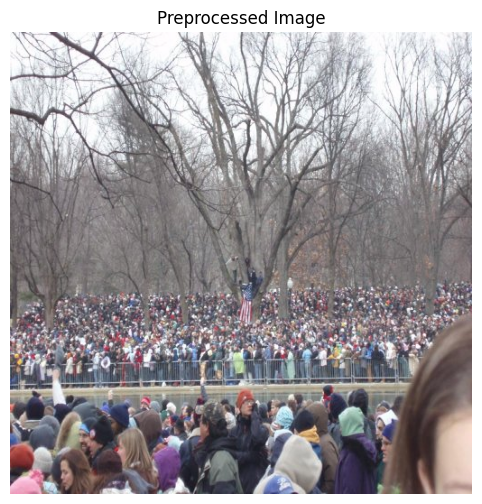

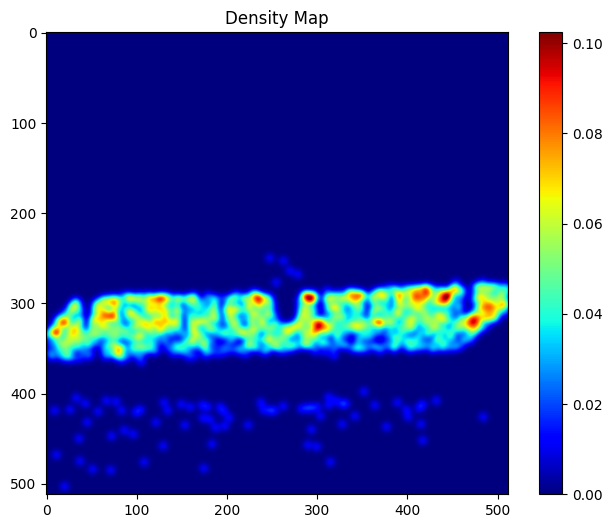

In [8]:
plt.figure(figsize=(8,6))
plt.imshow(img_tensor.permute(1,2,0))
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()

plt.figure(figsize=(8,6))
plt.imshow(density, cmap='jet')
plt.title("Density Map")
plt.colorbar()
plt.show()
